# 3D model for the full FTES experiment

This script corresponds to the model used in section 3.3.6 (Modelling of FTES experiment) of my master's thesis report.

In [1]:
!jupyter --version

Selected Jupyter core packages...
IPython          : 8.8.0
ipykernel        : 6.20.2
ipywidgets       : 7.7.2
jupyter_client   : 7.4.9
jupyter_core     : 5.1.4
jupyter_server   : 2.1.0
jupyterlab       : 3.5.3
nbclient         : 0.7.2
nbconvert        : 7.2.8
nbformat         : 5.7.3
notebook         : 6.5.2
qtconsole        : 5.4.0
traitlets        : 5.8.1


In [2]:
import numpy as np
import io
from mpi4py import MPI
import pyvista
import ufl
from ufl import Measure, FacetNormal
import matplotlib.pyplot as plt

import dolfinx
from dolfinx import fem, plot
from dolfinx.io import XDMFFile
from dolfinx.fem import FunctionSpace, VectorFunctionSpace, Constant, Function
from dolfinx.plot import create_vtk_mesh
from dolfinx.io.gmshio import read_from_msh

from petsc4py import PETSc
from petsc4py.PETSc import ScalarType

## Mesh reading

In [3]:
mesh, cell_tags, facet_tags = read_from_msh("../../meshes/3D/3D_FTES_mesh.msh", MPI.COMM_WORLD, 0)

Info    : Reading '../../Meshes/3D/3D_FTES_mesh.msh'...
Info    : 292 entities
Info    : 161517 nodes
Info    : 153691 elements                                               
Info    : Done reading '../../Meshes/3D/3D_FTES_mesh.msh'                  


In [4]:
print(np.unique(cell_tags.values))
print(np.unique(facet_tags.values))

[103 104 105 106 107]
[1 2]


## Experiment Setup Parameters

In [5]:
# Geometrical parameters
Dpipe = 0.001          # inner diameter of the pipe is 1mm
# Experimental parameter
Qinj = 0.25e-6/60*1/4  # flow rate injected by the pump (*1/4 because we only model 1/4 of the block)

# PART 1: fluid flow

## Submesh creation

In [6]:
print(f"DOLFINx version: {dolfinx.__version__} based on GIT commit: {dolfinx.git_commit_hash} of https://github.com/FEniCS/dolfinx/")

DOLFINx version: 0.6.0 based on GIT commit: 24f86a9ce57df6978070dbee22b3eae8bb77235f of https://github.com/FEniCS/dolfinx/


In [7]:
# create submesh to solve flow problem
submesh, entity_map, _, _ = dolfinx.mesh.create_submesh(mesh, mesh.topology.dim, cell_tags.indices[(cell_tags.values==106)|(cell_tags.values==107)])

In [8]:
# method to transfer facet tags from parent mesh to submesh
# source: https://fenicsproject.discourse.group/t/problem-transferring-facet-tags-to-submesh/11213
# CAREFUL: method works only for DOLFINx version v0.6.0
tdim = mesh.topology.dim
fdim = tdim - 1
c_to_f = mesh.topology.connectivity(tdim, fdim)
f_map = mesh.topology.index_map(fdim)
all_facets = f_map.size_local + f_map.num_ghosts
all_values = np.zeros(all_facets, dtype=np.int32)
all_values[facet_tags.indices] = facet_tags.values
print(np.unique(all_values))

submesh.topology.create_entities(fdim)
subf_map = submesh.topology.index_map(fdim)
submesh.topology.create_connectivity(tdim, fdim)
c_to_f_sub = submesh.topology.connectivity(tdim, fdim)
num_sub_facets = subf_map.size_local + subf_map.size_global
sub_values = np.empty(num_sub_facets, dtype=np.int32)
for i, entity in enumerate(entity_map):
    parent_facets = c_to_f.links(entity)
    child_facets = c_to_f_sub.links(i)
    for child, parent in zip(child_facets, parent_facets):
        sub_values[child] = all_values[parent]
sub_meshtag = dolfinx.mesh.meshtags(submesh, submesh.topology.dim-1, np.arange(
    num_sub_facets, dtype=np.int32), sub_values)

[0 1 2]


## Output file for fluid flow problem

In [9]:
xdmf = XDMFFile(submesh.comm, "solution_3D_FTES_fluidPressure_model.xdmf", "w")
xdmf.write_mesh(submesh)

## Finite element function space for pressure field

In [10]:
U = FunctionSpace(submesh, ("CG", 2))  # Lagrange quadratic elements (degree 2)

## Trial and test functions

In [11]:
p, u = ufl.TrialFunction(U), ufl.TestFunction(U)

## Boundary conditions

In [12]:
# DIRICHLET: p=pext on side 2
pext = 0
boundary_dofs = fem.locate_dofs_topological(U, submesh.topology.dim-1, sub_meshtag.indices[sub_meshtag.values == 2])
bc_inj = fem.dirichletbc(ScalarType(pext), boundary_dofs, U)

bc_tot = [bc_inj]

# NEUMANN: q=Qinj/A on side 1
qin = -4*Qinj/(np.pi*Dpipe**2)

## Custom integration measures

In [13]:
# integrate over subdomains
dx = Measure("dx", domain=submesh)
# integrate over boundaries
ds = Measure("ds", domain=submesh, subdomain_data=sub_meshtag)
n = FacetNormal(submesh)

## Variational problem

Here, the variational problem is straightforward as it involves a steady-state problem (of the Poisson equation type).

In [14]:
a = ufl.dot(ufl.grad(p), ufl.grad(u)) * dx
L = - qin * u * ds(1)

## Linear solver

In [15]:
%%time
problem = fem.petsc.LinearProblem(a, L, bcs=bc_tot, petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
p_h = problem.solve()
xdmf.write_function(p_h)
xdmf.close()

CPU times: user 23min 22s, sys: 4.82 s, total: 23min 27s
Wall time: 23min 28s


## Fluid flow

The fluid velocity field corresponds to the pressure gradient.

In [16]:
V = VectorFunctionSpace(submesh, ("CG", 1))
q_expr = fem.Expression(-ufl.grad(p_h), V.element.interpolation_points())
q_sub = fem.Function(V)
q_sub.interpolate(q_expr)

Uncomment the following cell to visualize the submesh and the fluid velocity field inside it.

In [17]:
# save fluid velocity field in another file to visualize in paraview
xdmf = XDMFFile(submesh.comm, "solution_3D_FTES_fluidVelocity_model.xdmf", "w")
xdmf.write_mesh(submesh)
xdmf.write_function(q_sub)
xdmf.close()

# PART 2: heat transfer

## Output file for heat transfer problem

In [18]:
xdmf = XDMFFile(mesh.comm, "solution_3D_FTES_temperature_model.xdmf", "w")
xdmf.write_mesh(mesh)

## Temporal parameters

In [19]:
t = 0              # start time
T = 100*8*3600.    # final time
num_steps = 200
dt = T / num_steps # time step size

Text = 20 # initial temperature in the system
Tinj = 70 # temperature of injected water

## Finite element function space for temperature field

In [20]:
W = FunctionSpace(mesh, ("CG", 1))  # Lagrange linear elements (degree 1)

## Initial conditions

In [21]:
T_n = Function(W)
T_n.name = "T_n"
T_n.x.array[:] = np.full(len(T_n.x.array), Text)

Store the initial condition in another variable as T_n undergoes changes at each iteration, ensuring that the initial temperature is preserved for calculating different energies at each step.

In [22]:
T_i = T_n.copy()
T_i.name = "T_i"

## Time-dependent output

In [23]:
T_h = T_n.copy()
T_h.name = "T_h"
xdmf.write_function(T_h, t)

## Trial and test functions

In [24]:
T, r = ufl.TrialFunction(W), ufl.TestFunction(W)

## Material properties

In [25]:
# for gabbro
rho_g = 3000                 # density of gabbro in kg/m³
c_g = 460                    # specific heat of gabbro in J/(kg*K)
cond_g = 2.15                # thermal conductivity of gabbro in W/(m·K)
print("Thermal diffusivity of gabbro:" + str(cond_g/(rho_g*c_g)))

# for water
rho_w = 997                  # density of water in kg/m³
c_w = 4182                   # specific heat of water in J/(kg*K)
cond_w = 0.598               # thermal conductivity of water in W/(m·K)
print("Thermal diffusivity of water:" + str(cond_w/(rho_w*c_w)))

# for metal (assume steel)
rho_m = 8000                 # density of metal in kg/m³
c_m = 420                    # specific heat of metal in J/(kg*K)
cond_m = 45                  # thermal conductivity of metal in W/(m·K)
print("Thermal diffusivity of metal:" + str(cond_m/(rho_m*c_m)))

# for epoxy resin
rho_e = 1100                 # density of epoxy resin in kg/m³
c_e = 1110                   # specific heat of epoxy resin in J/(kg*K)
cond_e = 0.14                # thermal conductivity of epoxy resin in W/(m·K)
print("Thermal diffusivity of epoxy resin:" + str(cond_e/(rho_e*c_e)))

# give those different properties to the domain
M = FunctionSpace(mesh, ("DG", 0))
metal_mask = (cell_tags.values == 103)
epoxy_mask = (cell_tags.values == 104)
rock_mask = (cell_tags.values == 105)
fluid_mask = (cell_tags.values == 106)|(cell_tags.values == 107)

rho = Function(M)
rho.x.array[metal_mask] = np.full(metal_mask.sum(), rho_m)
rho.x.array[epoxy_mask] = np.full(epoxy_mask.sum(), rho_e)
rho.x.array[rock_mask] = np.full(rock_mask.sum(), rho_g)
rho.x.array[fluid_mask] = np.full(fluid_mask.sum(), rho_w)

c = Function(M)
c.x.array[metal_mask] = np.full(metal_mask.sum(), c_m)
c.x.array[epoxy_mask] = np.full(epoxy_mask.sum(), c_e)
c.x.array[rock_mask] = np.full(rock_mask.sum(), c_g)
c.x.array[fluid_mask] = np.full(fluid_mask.sum(), c_w)

cond = Function(M)
cond.x.array[metal_mask] = np.full(metal_mask.sum(), cond_m)
cond.x.array[epoxy_mask] = np.full(epoxy_mask.sum(), cond_e)
cond.x.array[rock_mask] = np.full(rock_mask.sum(), cond_g)
cond.x.array[fluid_mask] = np.full(fluid_mask.sum(), cond_w)

Thermal diffusivity of gabbro:1.5579710144927536e-06
Thermal diffusivity of water:1.4342405504413766e-07
Thermal diffusivity of metal:1.3392857142857142e-05
Thermal diffusivity of epoxy resin:1.1466011466011467e-07


## Fluid flow

In [26]:
# function to transfer data from submesh to parent mesh
# source: https://gist.github.com/jorgensd/9170f86a9e47d22b73f1f0598f038773
def transfer_submesh_data(u_parent: dolfinx.fem.Function, u_sub: dolfinx.fem.Function,
                          sub_to_parent_cells: np.ndarray, inverse: bool = False):
    """
    Transfer data between a function from the parent mesh and a function from the sub mesh.
    Both functions has to share the same element dof layout
    Args:
        u_parent: Function on parent mesh
        u_sub: Function on sub mesh
        sub_to_parent_cells: Map from sub mesh (local index) to parent mesh (local index)
        inverse: If true map from u_sub->u_parent else u_parent->u_sub
    """
    V_parent = u_parent.function_space
    V_sub = u_sub.function_space
    # FIXME: In C++ check elementlayout for equality
    if inverse:
        for i, cell in enumerate(sub_to_parent_cells):
            bs = V_parent.dofmap.bs
            bs_sub = V_sub.dofmap.bs
            assert(bs == bs_sub)
            parent_dofs = V_parent.dofmap.cell_dofs(cell)
            sub_dofs = V_sub.dofmap.cell_dofs(i)
            for p_dof, s_dof in zip(parent_dofs, sub_dofs):
                for j in range(bs):
                    u_parent.x.array[p_dof * bs + j] = u_sub.x.array[s_dof * bs + j]
    else:
        for i, cell in enumerate(sub_to_parent_cells):
            bs = V_parent.dofmap.bs
            bs_sub = V_sub.dofmap.bs
            assert(bs == bs_sub)
            parent_dofs = V_parent.dofmap.cell_dofs(cell)
            sub_dofs = V_sub.dofmap.cell_dofs(i)
            for p_dof, s_dof in zip(parent_dofs, sub_dofs):
                for j in range(bs):
                    u_sub.x.array[s_dof * bs + j] = u_parent.x.array[p_dof * bs + j]

In [27]:
# transfer solution of fluid velocity field to parent mesh
Q = VectorFunctionSpace(mesh, ("CG", 1))
q = Function(Q)
q.x.array[:] = 0
transfer_submesh_data(q, q_sub, entity_map, inverse=True)
q.x.scatter_forward()

Uncomment the following cell to visualize the parent mesh and the fluid velocity field inside it.

## Boundary conditions

In [28]:
# DIRICHLET: T=Ti on side 1
boundary_dofs_inj = fem.locate_dofs_topological(W, mesh.topology.dim-1, facet_tags.indices[facet_tags.values == 1])
bc_inj = fem.dirichletbc(ScalarType(Tinj), boundary_dofs_inj, W)

bc_tot = [bc_inj]

## Custom integration measures

In [29]:
# integrate over subdomains
dx = Measure("dx", domain=mesh, subdomain_data=cell_tags)
# integrate over boundaries
ds = Measure("ds", domain=mesh, subdomain_data=facet_tags)
n = FacetNormal(mesh)

## Variational problem

In [30]:
F = rho * c * T * r * ufl.dx + dt * cond * ufl.dot(ufl.grad(T), ufl.grad(r)) * ufl.dx + dt * rho_w * c_w * ufl.dot(q, ufl.grad(T)) * r * ufl.dx \
    - (rho * c * T_n * r * ufl.dx)

In [31]:
a = ufl.lhs(F)
L = ufl.rhs(F)

## Linear algebra structures for the time dependent problem

In [32]:
bilinear_form = fem.form(a)
linear_form = fem.form(L)

In [33]:
%%time
# bilinear_form (a) isn't time dependant so we can assemble it once
A = fem.petsc.assemble_matrix(bilinear_form, bcs=bc_tot)
A.assemble()
b = fem.petsc.create_vector(linear_form)

CPU times: user 1.65 s, sys: 24 ms, total: 1.67 s
Wall time: 1.65 s


## Linear solver

In [34]:
%%time
solver = PETSc.KSP().create(mesh.comm)
solver.setOperators(A)
solver.setType(PETSc.KSP.Type.PREONLY)
solver.getPC().setType(PETSc.PC.Type.LU)
#solver.setType(PETSc.KSP.Type.GMRES)
#solver.setTolerances(rtol=1e-6, atol=1e-10, max_it=1000)
#solver.getPC().setType(PETSc.PC.Type.ILU)

CPU times: user 95 µs, sys: 0 ns, total: 95 µs
Wall time: 99.4 µs


In [35]:
%%time
E_stored = [0]  # at the initial state no energy is stored
E_input_conduction = [0]
E_input_advection = [0]
E_output_advection = [0]
for i in range(num_steps):
    t += dt

    # Update the right hand side reusing the initial vector
    with b.localForm() as loc_b:
        loc_b.set(0)
    fem.petsc.assemble_vector(b, linear_form)
    
    # Apply Dirichlet boundary condition to the vector
    fem.petsc.apply_lifting(b, [bilinear_form], [bc_tot])
    b.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    fem.petsc.set_bc(b, bc_tot)

    # Solve linear problem
    solver.solve(b, T_h.vector)
    T_h.x.scatter_forward()

    # Update solution at previous time step (u_n)
    T_n.x.array[:] = T_h.x.array
    
    # Write solution to file
    xdmf.write_function(T_h, t)
    
    # Compute stored energy
    I1 = fem.form(rho * c * (T_h-T_i) * dx((103, 104, 105, 106, 107)))
    E_stored.append(fem.assemble_scalar(I1))
    
    # Compute input energy by conduction   
    I2 = fem.form(dt * cond * ufl.dot(ufl.grad(T_h), n) * ds(1))
    #I2 = fem.form(dt * cond * ufl.dot(ufl.grad(T_h), ufl.grad(T_h))**(1/2) * ds(1))
    E_input_conduction.append(fem.assemble_scalar(I2))
    
    # Compute input energy by advection
    I3 = fem.form(dt * rho * c * ufl.dot(q, -n) * (T_h-T_i) * ds(1))
    E_input_advection.append(fem.assemble_scalar(I3))
    
    # Compute output energy by advection
    I4 = fem.form(dt * rho * c * ufl.dot(q, n) * (T_h-T_i) * ds(2))
    #I4 = fem.form(dt * rho * c * ufl.dot(q, q)**(1/2) * (T_h-T_i) * ds(2))
    E_output_advection.append(fem.assemble_scalar(I4))
    
    if i % 10 == 0:
        print(i)
        
xdmf.close()

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
CPU times: user 7min 13s, sys: 6.26 s, total: 7min 19s
Wall time: 7min 17s


In [39]:
Itest = fem.form(ufl.dot(q, n) * ds(2))
print("Flow in = ", Qinj/4)
print("Flow out = ", fem.assemble_scalar(Itest))
print("Flow in = Flow out !")

Flow in =  2.6041666666666667e-10
Flow out =  2.601193658346205e-10
Flow in = Flow out !


## Post-processing of results (energy balance)

The two graphs below are shown for informational purposes only because the current simulation is not energy conservative. Indeed, the energy stored in the system at each time step is different from the accumulated energy given to the system minus the energy that has left the system. In order for the simulation to be energy conservative, the interpolation order of the fluid pressure field must be increased to 4 instead of 2. The detailed explanation is provided directly in my Master's thesis report.

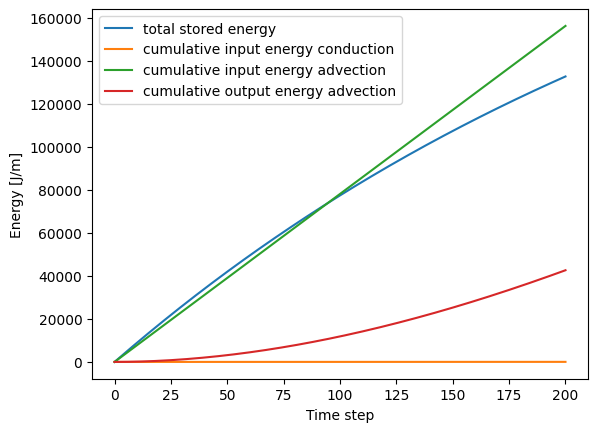

In [37]:
# Plot input and output energies to the system versus stored energy
plt.plot(np.array(E_stored), label = "total stored energy")
plt.plot(np.array(E_input_conduction).cumsum(), label = "cumulative input energy conduction")
plt.plot(np.array(E_input_advection).cumsum(), label = "cumulative input energy advection")
plt.plot(np.array(E_output_advection).cumsum(), label = "cumulative output energy advection")
plt.legend(loc="upper left")
plt.xlabel('Time step')
plt.ylabel('Energy [J/m]')
plt.show()

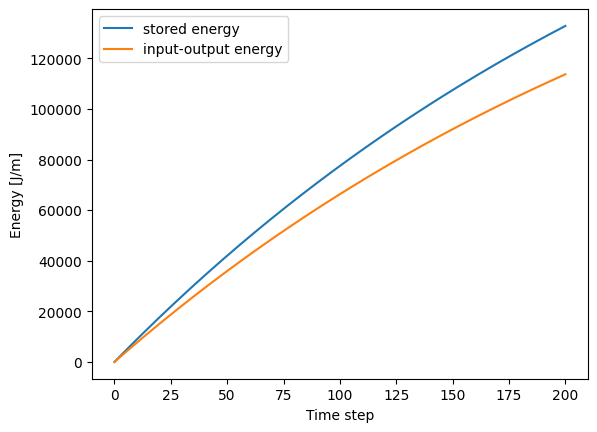

In [38]:
# Plot input-output energies to comparte with stored energy
plt.plot(np.array(E_stored), label = "stored energy")
plt.plot(np.array(E_input_conduction).cumsum()+np.array(E_input_advection).cumsum()-np.array(E_output_advection).cumsum(), label = "input-output energy")
plt.legend(loc="upper left")
plt.xlabel('Time step')
plt.ylabel('Energy [J/m]')
plt.show()